## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [105]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

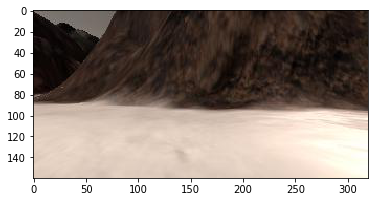

In [106]:
path = '../my_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

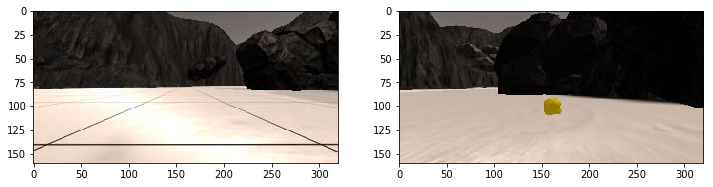

In [107]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

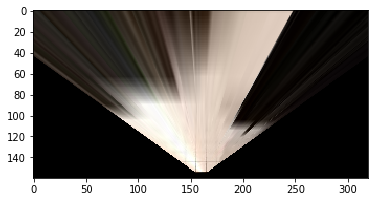

In [108]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Suggestion:** Think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  
**Beware:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

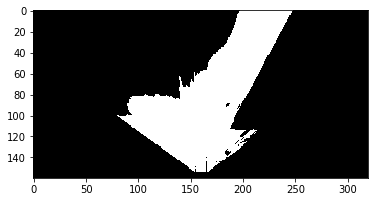

In [109]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

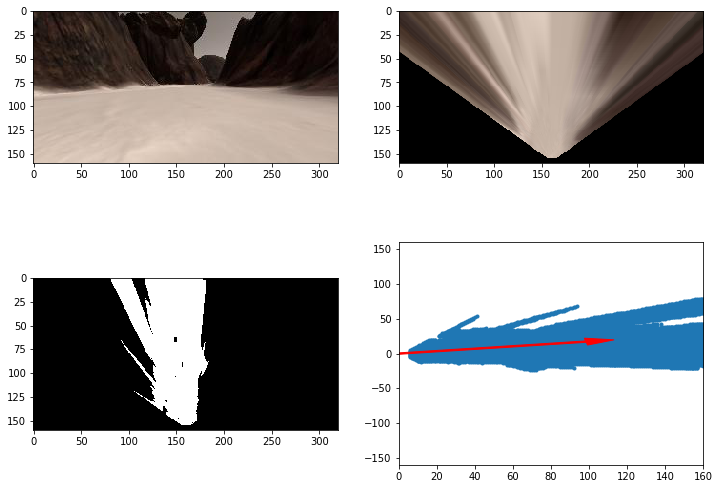

In [114]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    # Apply a rotation
    yaw_rad = np.float(yaw) * np.pi / 180.0
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = np.int32(np.float(xpos) + (xpix_rot / scale))
    ypix_translated = np.int32(np.float(ypos) + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)


## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [115]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
df = pd.read_csv('../my_dataset/robot_log.csv')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
#x = df["Yaw"].tolist()
#print(x)
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()
print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

46.60698 95.70319 358.2773


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [116]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    dst_size = 5
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
            [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
            [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
            [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
            ])
    
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    obstaclesel = color_thresh(warped, rgb_thresh=(100, 100, 100))
    terrainsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
    samplesel = color_thresh(warped, rgb_thresh=(0, 140, 140))
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    xpix_obstacle, ypix_obstacle = rover_coords(obstaclesel)
    xpix_sample, ypix_sample = rover_coords(samplesel)
    xpix_terrain, ypix_terrain = rover_coords(terrainsel)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = 10
    
    print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    obstacle_x_world, obstacle_y_world = pix_to_world(xpix_obstacle, ypix_obstacle, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)

    sample_x_world, sample_y_world = pix_to_world(xpix_sample, ypix_sample, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
                                                                
    terrain_x_world, terrain_y_world = pix_to_world(xpix_terrain, ypix_terrain, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
     
    
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    data.worldmap[sample_y_world, sample_x_world, 1] += 1
    data.worldmap[terrain_y_world, terrain_x_world, 2] += 1
    
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [117]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/my_test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

46.60698 95.70319 358.2773
[MoviePy] >>>> Building video ../output/my_test_mapping.mp4
[MoviePy] Writing video ../output/my_test_mapping.mp4



  0%|          | 8/2263 [00:00<00:28, 79.25it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556


99.66999 85.58897 56.82556



  1%|          | 26/2263 [00:00<00:27, 81.24it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.67012 85.5892 56.82413
99.6712 85.59083 56.90168
99.67337 85.59415 56.77652
99.67904 85.60278 56.62471
99.6851 85.61199 56.83175
99.69646 85.62922 56.64671
99.70698 85.64507 56.51482
99.71923 85.66341 56.6759
99.72996 85.68003 56.58849
99.74679 85.70553 56.5976
99.76245 85.72914 56.62796
99.78038 85.7561 56.60434


99.80697 85.79621 56.78425



  2%|▏         | 42/2263 [00:00<00:29, 75.92it/s]

99.82821 85.82827 56.77746
99.8586 85.87449 56.87291
99.88337 85.91209 56.84416
99.90984 85.95221 56.72618
99.93836 85.99536 56.69054
99.97883 86.05653 56.65662
100.0112 86.1054 56.6584
100.0567 86.17404 56.64794
100.0927 86.22822 56.61507
100.1302 86.28474 56.60535
100.1827 86.36373 56.57209
100.2239 86.4257 56.54742
100.2668 86.49012 56.51644
100.3113 86.55685 56.49259
100.3732 86.6495 56.4626



  2%|▏         | 56/2263 [00:00<00:30, 71.75it/s]

100.4215 86.7217 56.44752
100.4713 86.79621 56.43528
100.5402 86.89919 56.41895
100.5937 86.97912 56.40963
100.6675 87.08929 56.39242
100.7247 87.17452 56.38248
100.7834 87.2621 56.37122
100.8437 87.35194 56.35985
100.9264 87.47518 56.34577
100.9906 87.57004 56.26429
101.0574 87.66614 55.94111
101.1517 87.79563 55.00541
101.2254 87.89463 54.31482
101.3007 87.99576 53.88361



  3%|▎         | 70/2263 [00:00<00:31, 68.92it/s]

101.4031 88.13441 53.74789
101.4817 88.24073 53.72379
101.562 88.34921 53.7103
101.6714 88.497 53.69491
101.7554 88.61036 53.6836
101.8409 88.72569 53.67229
101.9571 88.88238 53.65917
102.0457 89.00166 53.64597
102.1348 89.12171 53.63043
102.2538 89.28179 53.60917
102.3425 89.40115 53.5935
102.4598 89.55884 53.5738
102.5479 89.67556 53.36377



  4%|▍         | 85/2263 [00:01<00:31, 69.23it/s]

102.6373 89.78999 52.79652
102.729 89.90141 51.88504
102.8556 90.04399 50.11569
102.9542 90.14617 48.41082
103.0555 90.24606 46.7025
103.1935 90.38035 44.95807
103.2992 90.48225 44.04312
103.4053 90.58139 43.39461
103.5455 90.71208 43.07025
103.6497 90.80952 43.03679
103.7535 90.90611 42.99929
103.8933 91.03132 42.49202
103.9998 91.12172 41.70773
104.1444 91.23656 40.1613
104.2549 91.31912 38.78315
104.3662 91.40022


  4%|▍         | 101/2263 [00:01<00:29, 72.70it/s]

 37.62901
104.4777 91.4809 36.79407
104.6262 91.58899 36.21556
104.737 91.6703 36.11573
104.8474 91.7511 36.10011
104.9939 91.85806 36.09696
105.1031 91.93778 36.09632
105.2118 92.01711 36.09584
105.3561 92.12235 36.09656
105.4641 92.20108 36.09631
105.5728 92.2802 36.09597
105.7197 92.38718 36.09559
105.8322 92.46906 36.09534
105.9863 92.58121 36.095
106.1052 92.66744 36.0889
106.2265 92.75498 36.07333
106.3501 92.84412 36.0563



  5%|▌         | 117/2263 [00:01<00:30, 69.73it/s]

106.5183 92.96512 36.02408
106.646 93.05663 36.00257
106.7723 93.14844 35.98759
106.9442 93.27253 35.96162
107.0763 93.3676 35.94478
107.2109 93.46438 35.92768
107.3937 93.59563 35.9046
107.5327 93.69546 35.88675
107.6739 93.79668 35.87288
107.8654 93.93393 35.85476
108.0114 94.03851 35.84115
108.1595 94.14453 35.82778
108.3596 94.28773 35.81137
108.5113


  6%|▌         | 132/2263 [00:01<00:31, 68.55it/s]

 94.39618 35.79486
108.6636 94.50501 35.7752
108.8674 94.64877 35.49168
109.0207 94.75375 34.8942
109.175 94.85435 33.92074
109.383 94.97964 32.00998
109.5407 95.06671 30.30191
109.699 95.14988 28.77561
109.9114 95.26041 27.30936
110.0727 95.34491 26.63626
110.2365 95.42981 26.41686
110.4545 95.5388 26.37845
110.6177 95.61975 26.3747
110.7816 95.70083 26.37411
111.0021 95.80985 26.37455



  6%|▋         | 146/2263 [00:02<00:32, 65.90it/s]

111.1698 95.89275 26.37509
111.34 95.97624 26.36134
111.5709 96.08911 26.33364
111.7468 96.17493 26.30742
111.9249 96.26125 26.26873
112.1646 96.3764 26.23031
112.3457 96.46587 26.24811
112.528 96.55624 26.25699
112.7741 96.67735 26.2491
112.9617 96.76927 26.23824
113.1515 96.862 26.22163
113.408 96.98701 26.20129
113.6028 97.08189 26.18438



  7%|▋         | 153/2263 [00:02<00:32, 64.49it/s]

113.7999 97.17774 26.16767
114.0659 97.30697 26.14385
114.2678 97.40501 26.12445
114.4719 97.50399 26.10583
114.7473 97.63745 26.08097
114.9563 97.73862 26.06036
115.1674 97.84071 26.0399
115.4522 97.97831 26.01408
115.6678 98.08238 25.99355
115.8847 98.18695 25.97057
116.1746 98.32654 25.93563
116.3916


  7%|▋         | 160/2263 [00:02<00:32, 65.11it/s]

 98.43094 25.90909
116.6073 98.53552 26.02216
116.8903 98.67817 


  7%|▋         | 168/2263 [00:02<00:31, 66.99it/s]

26.72794
117.0982 98.78893 27.71632
117.3015 98.90421 29.08827
117.5636 99.06683 31.51501
117.7581 99.19389 33.50643
117.9515 99.32502 35.5967
118.2056 99.51 38.49817
118.3888 99.65505 40.37712
118.5601 99.80598 41.87802
118.7826 100.0132 43.23909
118.9477 100.1703 43.8031
119.1124 100.3273 43.99693
119.3299 100.5365 44.05922
119.492 100.6929 44.06789



  8%|▊         | 176/2263 [00:02<00:30, 69.36it/s]

119.6532 100.8487 44.06955
119.8671 101.0555 44.06647



  8%|▊         | 184/2263 [00:02<00:29, 70.49it/s]

120.0267 101.21 44.0662
120.1858 101.3638 44.06332
120.3967 101.5687 44.12997
120.5521 101.7237 44.51617
120.705 101.8807 45.26429
120.9018 102.0951 46.91528
121.0431 102.2605 48.61825
121.1793 102.4304 50.57426
121.3549 102.6644 53.21675
121.4821 102.8417 55.14698
121.6008 103.0168 56.99142
121.7467 103.2529 58.75581
121.8534 103.4327 59.50966
121.9599 103.6135 59.88622


  8%|▊         | 192/2263 [00:02<00:28, 71.79it/s]


122.1002 103.8544 60.0039
122.2044 104.0345


  9%|▉         | 200/2263 [00:02<00:28, 72.72it/s]

 60.01963
122.3079 104.2138 60.02463
122.4451 104.4518 60.02694
122.5474 104.6294 60.0279
122.6496 104.8064 60.02393
122.785 105.0415 60.02222
122.8859 105.2176 60.03318
122.9857 105.3937 60.19573
123.1138 105.6301 60.9851
123.205 105.8089 62.04494
123.2936 105.9888 63.15783
123.4095 106.2289 64.16544
123.4965 106.4089 64.48247
123.5835 106.5887 64.55694
123.6979 106.8274 64.57359



  9%|▉         | 208/2263 [00:02<00:27, 74.61it/s]

123.7829 107.0055 64.57497
123.8674 107.1827 64.57544



 10%|▉         | 216/2263 [00:03<00:27, 75.60it/s]

123.9795 107.4174 64.57312
124.063 107.5925 64.57106
124.146 107.7668 64.5691
124.2562 107.9979 64.56677
124.3382 108.1704 64.56631
124.4201 108.3423 64.56316
124.5285 108.5704 64.5629
124.6097 108.7408 64.55809
124.6904 108.9106 64.55731
124.7973 109.1366 64.5668
124.8774 109.3055 64.57098
124.9571 109.4743 64.58242
125.0614 109.699 64.86024
125.136 109.8681 65.47859



 10%|▉         | 224/2263 [00:03<00:26, 75.91it/s]

125.2071 110.0384 66.46306
125.2932 110.2678 68.40873



 10%|█         | 232/2263 [00:03<00:26, 75.68it/s]

125.3512 110.4419 70.25551
125.4047 110.6185 72.18865
125.4681 110.8546 74.79684
125.5116 111.0266 76.57738
125.5471 111.1984 77.95833
125.5901 111.4292 79.1741
125.6214 111.6025 79.65704
125.6526 111.7752 79.80388
125.6938 112.0043 79.84168
125.7246 112.1756 79.84332
125.7551 112.3463 79.84355
125.7955 112.573 79.84435
125.8251 112.7424 79.92159
125.8522 112.9119 80.28235



 11%|█         | 240/2263 [00:03<00:26, 76.06it/s]

125.8829 113.1379 81.34851
125.901 113.3076 82.5859



 11%|█         | 248/2263 [00:03<00:26, 76.45it/s]

125.9132 113.4773 84.19775
125.9208 113.704 86.75413
125.9215 113.876 88.65266
125.916 114.0457 90.65155
125.9031 114.2636 93.43082
125.8858 114.4239 95.09406
125.8658 114.5856 96.34207
125.8355 114.8012 97.50803
125.812 114.9621 97.97354
125.7892 115.1224 98.10446
125.7589 115.3349 98.13489
125.7361 115.4939 98.13879
125.7132 115.6534 98.14005
125.6823 115.8684 98.14084



 11%|█▏        | 256/2263 [00:03<00:26, 76.28it/s]

125.6587 116.0323 98.14133
125.6346 116.1992 98.14178



 12%|█▏        | 264/2263 [00:03<00:26, 75.54it/s]

125.6015 116.4269 98.14816
125.5759 116.6007 98.1644
125.5498 116.7771 98.18243
125.5141 117.0161 98.21677
125.4862 117.1973 98.25711
125.4598 117.3794 98.23013
125.4258 117.6235 98.19916
125.3998 117.8096 98.18146
125.3736 117.9979 98.16119
125.3384 118.2507 98.13376
125.3117 118.4407 98.18405
125.283 118.6297 98.51178
125.2393 118.8785 99.56061



 12%|█▏        | 272/2263 [00:03<00:26, 74.50it/s]

125.2012 119.062 100.8019
125.1575 119.2422 102.4089



 12%|█▏        | 280/2263 [00:03<00:26, 75.09it/s]

125.09 119.4763 105.0759
125.0361 119.6498 107.0681
124.9792 119.8255 109.0557
124.8909 120.0575 111.6157
124.8143 120.2279 113.495
124.7297 120.3922 115.6121
124.6112 120.6019 118.5081
124.519 120.7549 120.2884
124.4236 120.9071 121.6333
124.2928 121.1081 122.8718
124.1939 121.2576 123.369
124.0957 121.4066 123.5146
123.9652 121.6039 123.5518
123.8678 121.7509 123.5565



 13%|█▎        | 288/2263 [00:03<00:26, 75.75it/s]

123.7708 121.8973 123.5566
123.6437 122.0927 123.2813



 13%|█▎        | 296/2263 [00:04<00:26, 75.32it/s]

123.5517 122.2402 122.6724
123.4637 122.389 121.6901
123.3526 122.5909 119.8028
123.2744 122.745 118.1356
123.1976 122.9013 116.6804
123.0968 123.109 115.2369
123.0256 123.2616 114.4828
122.957 123.4143 114.1541
122.8659 123.6173 114.0699
122.7981 123.769 114.0603
122.7303 123.9202 114.0895
122.6372 124.1196 114.5974
122.5641 124.2667 115.4118
122.4879 124.4123 116.562


122.3799 124.603 118.4952
122.2965 124.7474 119.6618



 14%|█▍        | 312/2263 [00:04<00:25, 75.66it/s]

122.2108 124.8907 120.5417
122.0998 125.0774 121.217
122.0175 125.2147 121.3616
121.9346 125.3509 121.3908
121.8246 125.5313 121.3983
121.7424 125.6658 121.3998
121.6606 125.7998 121.4008
121.5519 125.9778 121.3996
121.4706 126.1108 121.3982
121.3895 126.2434 121.3983
121.2807 126.4203 121.4114
121.1984 126.5541 121.4221
121.1157 126.6892 121.4242
121.0034 126.8727 121.4254



 14%|█▍        | 320/2263 [00:04<00:25, 76.11it/s]

120.9173 127.0134 121.4262
120.8293 127.1571 121.4271



 14%|█▍        | 328/2263 [00:04<00:25, 75.08it/s]

120.7093 127.3519 121.4461
120.6181 127.4998 121.4632
120.5264 127.6484 121.4832
120.4039 127.8462 121.5157
120.3142 127.9938 121.501
120.2257 128.1395 121.4832
120.1094 128.3321 121.3869
120.0245 128.4761 120.9944
119.9429 128.6207 120.2492
119.8414 128.8151 118.6604
119.772 128.9623 117.0477
119.709 129.1107 115.1328
119.6279 129.3118 112.8169


119.5666 129.4656 111.4747
119.5069 129.6215 110.4146
119.4335 129.8281 


 15%|█▌        | 344/2263 [00:04<00:25, 75.28it/s]

109.5766
119.3798 129.9818 109.3285
119.3264 130.1347 109.2789
119.2557 130.3373 109.2674
119.203 130.4884 109.2659
119.1507 130.6388 109.2655
119.0812 130.8383 109.2653
119.0296 130.9876 109.2594
118.977 131.1363 109.4061
118.9029 131.3325 110.1557
118.8461 131.4788 110.7303
118.7899 131.6248 111.0113
118.7156 131.8191 111.0882
118.6596 131.9643 111.0598


118.604 132.1089 111.0541
118.5303 132.3008 111.0528



 16%|█▌        | 360/2263 [00:04<00:26, 72.36it/s]

118.4752 132.4445 111.051
118.4197 132.5887 111.0413
118.3449 132.783 111.0128
118.2879 132.9312 111.001
118.2299 133.0822 110.998
118.1508 133.2884 110.994
118.0906 133.4463 110.9819
118.0292 133.6066 110.9741
117.9447 133.8231 111.0074
117.8816 133.9859 110.9972
117.8191 134.1487 110.9539
117.735 134.3705 110.9273
117.6708 134.5402 110.9089
117.6057 134.7126 110.89
117.5176


 16%|█▋        | 368/2263 [00:05<00:27, 69.84it/s]

 134.9464 110.8638
117.4508 135.1239 110.8444
117.3833 135.3035 110.828
117.2919 135.5468 110.8063
117.2224 135.732 110.7921
117.1522 135.9194 110.7752
117.0573 136.1729 110.7542
116.9852 136.3656 110.7381
116.9123 136.5606 110.7224
116.8139 136.8241 110.6997
116.7393 137.0243 110.6835



 17%|█▋        | 376/2263 [00:05<00:28, 67.15it/s]

116.6638 137.2268 110.6653
116.5621 137.5002 110.6433
116.4849 137.7078 110.6242



 17%|█▋        | 383/2263 [00:05<00:28, 64.99it/s]

116.4069 137.9177 110.6058
116.3019 138.2009 110.5821
116.2223 138.4158 110.5614
116.1419 138.633 110.5422
116.0336 138.9259 110.5165
115.9515 139.1481 110.4949
115.8688 139.3725 110.4757
115.7573 139.6751 110.4474
115.673 139.9044 110.4257
115.5879 140.136 110.4042



 17%|█▋        | 390/2263 [00:05<00:29, 64.00it/s]

115.4734 140.4481 110.3733
115.3868 140.6846 110.3499
115.2995 140.9232 110.328



 18%|█▊        | 397/2263 [00:05<00:29, 63.19it/s]

115.182 141.2447 110.2951
115.0931 141.4883 110.2706
115.0037 141.7339 110.2482
114.8833 142.0647 110.213
114.7923 142.3152 110.1876
114.7007 142.5678 110.1614
114.5776 142.9079 110.128
114.4846 143.1653 110.0957
114.391 143.4246 110.0628
114.2652 143.7739 110.0193



 18%|█▊        | 404/2263 [00:05<00:29, 62.79it/s]

114.1702 144.0383 109.9865
114.0747 144.3045 109.9503
113.9464 144.6629 109.9045



 18%|█▊        | 411/2263 [00:05<00:30, 61.12it/s]

113.8496 144.9339 109.8667
113.7523 145.2069 109.8315
113.6216 145.5743 109.7856
113.523 145.8522 109.7511
113.424 146.1318 109.7172
113.291 146.5079 109.6711
113.191 146.7917 109.6361
113.091 147.0759 109.5957
112.9584 147.4537 109.546


112.8596 147.7359 109.4833
112.7607 148.019 109.4456
112.6289 148.397 109.3756



 19%|█▊        | 424/2263 [00:06<00:31, 58.56it/s]

112.5301 148.6813 109.3412
112.4313 148.9661 109.3228
112.2999 149.3457 109.2549
112.2014 149.6311 109.2311
112.1032 149.9162 109.1838
111.9725 150.2971 109.1427
111.8756 150.5802 109.1105
111.7785 150.8642 109.0739
111.6493 151.2434 109.0248
111.5524 151.5282 108.9853
111.4555 151.8135 108.9539
111.3265 152.1943 108.9206



 19%|█▉        | 437/2263 [00:06<00:30, 59.38it/s]

111.2302 152.4794 108.8528
111.1339 152.7651 108.8133
111.0066 153.1441 108.7853
110.9112 153.4286 108.7487
110.8159 153.7134 108.716
110.6894 154.0922 108.6671
110.5948 154.3759 108.6346
110.5005 154.659 108.6043
110.3757 155.0345 108.5676
110.2827 155.3142 108.5426
110.1903 155.5926 108.5204
110.0675 155.9618 108.4978
109.9757 156.2375 108.4881
109.8842


 20%|█▉        | 451/2263 [00:06<00:28, 63.09it/s]

 156.5134 108.4688
109.7619 156.8801 108.4604
109.6704 157.1546 108.4573
109.579 157.4283 108.4568
109.4576 157.7927 108.4519
109.3668 158.065 108.451
109.2761 158.3367 108.4515
109.1554 158.6981 108.4535
109.0653 158.9681 108.4539
108.9756 159.237 108.4541
108.8565 159.5952 108.4443
108.7673 159.8627 108.4417
108.6784 160.1291 108.4409
108.5605 160.4826 108.4407
108.4717 160.7469 108.4565
108.3835 161.0104 108.4658



 21%|██        | 467/2263 [00:06<00:26, 68.63it/s]

108.2668 161.36 108.4692
108.1797 161.621 108.4697
108.0934 161.8818 108.4519
107.9782 162.2275 108.4452
107.8922 162.4855 108.4439
107.8065 162.7423 108.4435
107.6925 163.0839 108.4456
107.6074 163.3389 108.4465
107.5227 163.5928 108.4469
107.4096 163.9301 108.4597
107.3253 164.1821 108.4669
107.2416 164.4332 108.4692
107.1307 164.7671 108.4538
107.0477 165.0163 108.449
106.9649 165.2644 108.4474
106.855 165.5939 108.4463



 21%|██▏       | 483/2263 [00:06<00:25, 70.35it/s]

106.7728 165.8403 108.4473
106.6909 166.0856 108.4476
106.5819 166.4113 108.4549
106.5004 166.6548 108.4648
106.4193 166.8974 108.4679
106.3122 167.2198 108.4572
106.232 167.4606 108.4508
106.152 167.7004 108.4487
106.0459 168.0186 108.4481
105.9663 168.2567 108.4505
105.8872 168.4938 108.4515
105.7822 168.8084 108.4519
105.7035 169.0436 108.457
105.6252 169.278 108.4597
105.5214 169.5891 108.4607



 22%|██▏       | 491/2263 [00:06<00:24, 71.15it/s]

105.4442 169.8218 108.4495
105.367 170.0536 108.4436
105.2651 170.359 108.4413
105.19 170.5821 108.4601
105.1167 170.802 108.4597
105.019 171.0952 108.4563
104.9456 171.3154 108.4526
104.8721 171.536 108.4502
104.7738 171.8301 108.453
104.7006 172.0496 108.4536



 22%|██▏       | 499/2263 [00:07<00:25, 70.42it/s]

104.6277 172.2682 108.4537
104.531 172.5581 108.4537
104.4588 172.7744 108.4537
104.387 172.9897 108.4536
104.2918


 22%|██▏       | 507/2263 [00:07<00:24, 70.41it/s]

 173.2755 108.4484
104.2208 173.489 108.4424
104.1499 173.7015 108.4408
104.0559 173.9834 108.4403
103.9853 174.194 108.4502
103.9152 174.4037 108.4526
103.8224 174.6821 108.4534
103.7529 174.8902 108.4544
103.6837 175.0975 108.4547
103.5922 175.3728 108.4464
103.5237 175.5785 108.4424



 23%|██▎       | 515/2263 [00:07<00:24, 70.33it/s]

103.4554 175.7833 108.4413
103.3641 176.0555 108.4531
103.2964 176.2583 108.4548
103.2302 176.4579 108.445
103.1438


 23%|██▎       | 523/2263 [00:07<00:24, 70.32it/s]

 176.7156 108.4536
103.0795 176.9078 108.4603
103.0158 177.1009 108.4406
102.9298 177.3578 108.4443
102.8651 177.5507 108.4611
102.8008 177.7431 108.4654
102.7159 177.9996 108.4495
102.6527 178.1911 108.3712
102.5918 178.3824 108.0126
102.5167 178.6378 106.9158
102.4653 178.8298 105.7884



 23%|██▎       | 531/2263 [00:07<00:24, 70.70it/s]

102.4157 179.022 104.8292
102.3503 179.2782 104.1204
102.3017 179.4696 103.9625
102.2538 179.66 103.9234
102.1905 179.9114 103.9222



 24%|██▍       | 539/2263 [00:07<00:24, 70.08it/s]

102.1437 180.0985 103.9243
102.0972 180.2847 103.9255
102.0361 180.5316 103.8523
101.9931 180.7166 103.4573
101.9537 180.9016 102.6921
101.909 181.1487 101.0462
101.8792 181.3345 99.78937
101.8506 181.5211 98.8468
101.8144 181.7679 98.14282



 24%|██▍       | 547/2263 [00:07<00:24, 69.19it/s]

101.7879 181.9515 97.99481
101.7618 182.1343 97.96234
101.7282 182.3771 97.87918
101.7056 182.5587 97.4841
101.6867 182.7401 96.71893



 24%|██▍       | 554/2263 [00:07<00:24, 68.75it/s]

101.6689 182.9816 95.09146
101.662 183.1628 93.47177
101.6607 183.345 91.58829
101.6669 183.5838 88.87065
101.6778 183.7608 86.90295
101.6959 183.9365 85.13364
101.725 184.1692 83.32938
101.7495 184.3431 82.41795
101.7749 184.5163 81.86598
101.808


 25%|██▍       | 561/2263 [00:08<00:24, 68.32it/s]

 184.7461 81.68108
101.8328 184.9176 81.65945
101.8577 185.0882 81.65587
101.89 185.3098 81.65815
101.9132 185.4705 81.6655



 25%|██▌       | 569/2263 [00:08<00:24, 69.25it/s]

101.9365 185.6311 81.6749
101.9674 185.8428 81.68407
101.9905 185.9965 81.69391
102.0146 186.1469 81.66663
102.0451 186.3419 81.40828
102.0646 186.4768 81.30974
102.0853 186.6102 81.29997
102.1126 186.7882 81.30021
102.1329 186.9212 81.30017
102.1532 187.0535 81.30012
102.1801 187.2291


 25%|██▌       | 576/2263 [00:08<00:24, 68.93it/s]

 81.30005
102.2002 187.36 81.30001
102.2201 187.4901 81.3
102.2457 187.6574 81.30015



 26%|██▌       | 583/2263 [00:08<00:24, 67.89it/s]

102.264 187.7745 81.29272
102.2809 187.8815 81.27475
102.2995 188.0071 81.30093
102.3131 188.0958 81.3432
102.3259 188.1809 81.38579
102.3422 188.2891 81.42619
102.3539 188.3663 81.45086
102.364 188.4338 81.46711
102.3727 188.4898 81.57921
102.3761 188.5105 81.5977
102.3757 188.5165 81.83557



 26%|██▌       | 590/2263 [00:08<00:24, 68.18it/s]

102.3756 188.5167 81.86275
102.3756 188.5168 81.86738
102.3757 188.5169 81.85844



 26%|██▋       | 598/2263 [00:08<00:24, 68.79it/s]

102.3757 188.5169 81.86314
102.3756 188.5165 81.86293
102.3756 188.5163 81.86311
102.3755 188.516 81.87395
102.3756 188.5158 81.87532
102.3755 188.5157 81.87347
102.3753 188.5156 82.04852
102.3756 188.5156 82.77212
102.3757 188.5158 83.94356
102.3757 188.5159 86.2907
102.3757 188.516 88.63033
102.3758 188.5162 91.33084


102.3758 188.5163 94.93155
102.3758 188.5164 97.63202
102.3758 188.5165 100.3317



 27%|██▋       | 614/2263 [00:08<00:23, 71.27it/s]

102.3759 188.5165 103.9277
102.3759 188.5165 106.6264
102.376 188.5164 109.3259
102.3762 188.5164 112.926
102.3764 188.5163 115.6286
102.3767 188.5163 118.3326
102.3767 188.5162 121.9313
102.3768 188.5162 124.6338
102.3767 188.5161 127.3334
102.3767 188.5161 130.9321
102.3767 188.516 133.6308
102.3767 188.516 136.3296
102.3767 188.5159 139.9281
102.3767 188.5159 142.6269
102.3767 188.5159 145.3255
102.3767 188.5158 148.9235



 28%|██▊       | 631/2263 [00:08<00:21, 75.09it/s]

102.3767 188.5158 151.6218
102.3767 188.5158 154.3198
102.3767 188.5157 157.9169
102.3766 188.5157 160.6143
102.3767 188.5157 163.3148
102.3767 188.5157 166.915
102.3767 188.5157 169.6151
102.3768 188.5158 172.3151
102.3768 188.5158 175.915
102.3768 188.5158 178.615
102.3768 188.5158 181.3149
102.3768 188.5159 184.9147
102.3768 188.5159 187.6145
102.3768 188.5159 190.3143
102.3769 188.5159 193.9107
102.3773 188.5157 196.5957
102.3776 188.5155 199.283



 29%|██▊       | 648/2263 [00:09<00:20, 77.35it/s]

102.3781 188.5153 202.8695
102.3784 188.5152 205.5617
102.3787 188.5151 208.2558
102.3787 188.5152 211.8544
102.3787 188.5152 214.5549
102.3787 188.5152 217.2555
102.3787 188.5151 220.8559
102.3787 188.5151 223.5558
102.3787 188.5151 226.2557
102.3786 188.5151 229.8554
102.3786 188.515 232.555
102.3786 188.515 235.2543
102.3785 188.515 238.8532
102.3784 188.5149 241.552
102.3784 188.5149 244.2505
102.3783 188.5148 247.8478



 29%|██▉       | 664/2263 [00:09<00:20, 76.43it/s]

102.3782 188.5147 250.5453
102.3782 188.5147 253.2419
102.3782 188.5146 256.8417
102.3783 188.5146 259.5415
102.3783 188.5146 262.2414
102.3783 188.5146 265.8414
102.3784 188.5146 268.5414
102.3784 188.5146 270.88
102.3784 188.5147 273.2139
102.3784 188.5147 274.3835
102.3784 188.5147 275.1015
102.3784 188.5147 275.2789
102.3784 188.5147 275.2789
102.3784 188.5147 275.2789
102.3784 188.5147 275.279



 30%|███       | 680/2263 [00:09<00:21, 72.12it/s]

102.3784 188.5147 275.279
102.3783 188.5148 275.279
102.3783 188.5148 275.279
102.3783 188.5148 275.2791
102.3783 188.5148 275.2791
102.3783 188.5148 275.2791
102.3783 188.5148 275.2791
102.3783 188.5148 275.279
102.3783 188.5148 275.279
102.3782 188.5148 275.279
102.3782 188.5148 275.279
102.3782 188.5148 275.279
102.3782 188.5148 275.279
102.3782 188.5148 275.279



 30%|███       | 688/2263 [00:09<00:22, 71.01it/s]

102.3782 188.5148 275.279
102.3782 188.5148 275.279
102.3782 188.5148 275.279
102.3782 188.5148 275.279
102.3782 188.5148 275.279
102.3782 188.5148 275.2789
102.3783 188.5142 275.3332
102.3783 188.5136 275.3981
102.3786 188.5105 275.4846
102.3795 188.5016 275.4954
102.3803 188.4918 275.6129



 31%|███       | 696/2263 [00:09<00:22, 70.06it/s]

102.3814 188.4788 275.6217
102.384 188.4558 275.4532
102.3861 188.4346 275.3625



 31%|███       | 704/2263 [00:09<00:22, 70.74it/s]

102.3879 188.4137 275.325
102.3905 188.3853 275.2928
102.3929 188.3589 275.3435
102.3956 188.329 275.4351
102.3998 188.283 275.5177
102.4034 188.2452 275.5909
102.4072 188.2054 275.6431
102.4127 188.1485 275.7348
102.4171 188.1024 275.7438
102.422 188.0525 275.8634
102.429 187.9808 275.9344
102.4346 187.9241 275.9895



 31%|███▏      | 712/2263 [00:10<00:21, 70.56it/s]

102.4406 187.8643 275.9854
102.4491 187.7805 275.9927
102.4558 187.714 276.0341



 32%|███▏      | 720/2263 [00:10<00:21, 70.71it/s]

102.4628 187.6451 276.041
102.4726 187.5484 275.9793
102.4803 187.4727 275.948
102.4882 187.3941 275.9226
102.4991 187.285 275.8965
102.5076 187.1999 275.8799
102.5163 187.1119 275.8643
102.5283 186.9903 275.851
102.5376 186.8961 275.8403
102.547 186.8 275.8328
102.5598 186.6699 275.8203
102.5694 186.5716 275.8102


102.5791 186.4724 275.8001
102.5923 186.3369 275.7866
102.6025 186.232 275.7763



 33%|███▎      | 736/2263 [00:10<00:21, 70.98it/s]

102.613 186.1239 275.7656
102.6274 185.976 275.7502
102.6383 185.8628 275.74
102.6495 185.747 275.7281
102.6648 185.5878 275.7115
102.6765 185.4653 275.6981
102.6885 185.3402 275.6879
102.7048 185.1692 275.6722
102.7173 185.0378 275.6602
102.73 184.9039 275.6497
102.7474 184.7211 275.634
102.7606 184.5811 275.6227
102.7741 184.4384 275.611
102.7923 184.2441 275.5974
102.8063 184.0954 275.5844



 33%|███▎      | 752/2263 [00:10<00:21, 69.91it/s]

102.8204 183.9441 275.5725
102.8397 183.7383 275.557
102.8543 183.5809 275.5455
102.8692 183.421 275.5341
102.8893 183.2039 275.5191
102.9046 183.0382 275.5078
102.9201 182.87 275.4962
102.941 182.6422 275.4811
102.9569 182.4693 275.465
102.9727 182.2956 275.4465
102.9938 182.0642 275.4214
103.0094 181.8916 275.403
103.026 181.7204 275.546
103.0525 181.4947 276.3037
103.077 181.3276


 34%|███▍      | 768/2263 [00:10<00:20, 73.07it/s]

 277.3108
103.1063 181.1627 278.678
103.1507 180.9453 280.5382
103.1857 180.7816 281.5924
103.2204 180.6152 282.2629
103.2679 180.3919 282.5866
103.3061 180.2265 282.8431
103.347 180.0632 283.4139
103.4075 179.8495 284.7762
103.4552 179.6914 285.8016
103.5034 179.5343 286.5173
103.5667 179.3252 286.882
103.6138 179.1688 286.9249
103.6609 179.0129 286.9304
103.7235 178.8059 286.9282
103.7705 178.6513 286.9283
103.8172 178.4971 286.924



 35%|███▍      | 784/2263 [00:11<00:19, 74.94it/s]

103.8801 178.2925 287.0015
103.9294 178.1404 287.3965
103.9818 177.9899 288.1442
104.0542 177.7905 289.1926
104.1083 177.6412 289.6344
104.1616 177.4923 289.7568
104.2325 177.2945 289.7804
104.2855 177.1467 289.7801
104.3384 176.9994 289.7801
104.4087 176.804 289.7802
104.4611 176.6581 289.7804
104.5134 176.5128 289.7805
104.5828 176.3195 289.7755
104.6347 176.1752 289.7747
104.6865 176.0315 289.7747
104.7555 175.8405 289.7823



 35%|███▌      | 800/2263 [00:11<00:19, 73.90it/s]

104.807 175.6979 289.7835
104.8584 175.5556 289.7888
104.9265 175.3667 289.7907
104.9772 175.2256 289.7909
105.028 175.0851 289.7955
105.0953 174.8984 289.797
105.1454 174.7591 289.7971
105.1957 174.6203 289.8301
105.2656 174.4373 290.3322
105.321 174.3018 291.1138
105.3796 174.1681 292.1804
105.4585 173.9907 293.2603
105.5173 173.8582 293.6816
105.5753 173.7258 293.7879
105.6522 173.5501 293.8057



 36%|███▌      | 816/2263 [00:11<00:19, 75.38it/s]

105.7097 173.4191 293.8062
105.7669 173.2887 293.8038
105.8381 173.1179 293.6643
105.8866 172.9926 293.4668
105.938 172.8663 293.1838
106.0124 172.6964 293.0967
106.0686 172.5682 293.1229
106.1227 172.4395 293.3773
106.195 172.2646 293.7157
106.2534 172.136 293.7989
106.3112 172.0077 293.8347
106.387 171.8366 293.85
106.4434 171.7093 293.8565
106.4992 171.5829 293.8597
106.5724 171.4161 293.8545
106.6252 171.2916 293.6372



 37%|███▋      | 832/2263 [00:11<00:18, 76.27it/s]

106.6753 171.167 293.1074
106.7369 171.0001 291.8602
106.778 170.8744 290.5331
106.8147 170.7486 288.9637
106.8614 170.5805 287.2235
106.8958 170.4538 286.2868
106.93 170.3268 285.6556
106.9777 170.1566 285.366
107.0133 170.029 285.3448
107.0472 169.9025 285.2698
107.0933 169.7336 285.2076
107.1281 169.6057 285.2031
107.1633 169.476 285.2028
107.2113 169.2994 285.2396
107.2474 169.1633 285.4104
107.2857 169.0253 285.4958



 37%|███▋      | 840/2263 [00:11<00:19, 74.85it/s]

107.3382 168.8368 285.5255
107.3771 168.6923 285.5007
107.415 168.547 285.4521
107.4617 168.3573 285.5004
107.501 168.2143 285.4714
107.5424 168.0668 285.4274
107.5989 167.8638 285.4275
107.6413 167.7069 285.5729
107.6856 167.5475 285.7257
107.7472 167.3303 285.7755
107.7939 167.1638 285.7769
107.841 166.9944 285.761


 37%|███▋      | 848/2263 [00:11<00:18, 75.19it/s]


107.9048 166.7643 285.7326
107.9537 166.5889 285.7197
108.003 166.4116 285.7039



 38%|███▊      | 856/2263 [00:12<00:19, 72.74it/s]

108.0685 166.1754 285.6776
108.1181 165.9957 285.6586
108.1685 165.8132 285.6384
108.2367 165.5653 285.6111
108.2887 165.3763 285.5904
108.3412 165.1853 285.57
108.4118 164.9276 285.5438
108.4655 164.7314 285.5266
108.5197 164.5328 285.5079
108.5929 164.2645 285.4868
108.6485 164.0606 285.47



 38%|███▊      | 864/2263 [00:12<00:20, 69.02it/s]

108.7046 163.8543 285.4528
108.7803 163.5759 285.4303



 38%|███▊      | 871/2263 [00:12<00:21, 65.02it/s]

108.8377 163.3643 285.4119
108.8956 163.1505 285.3937
108.9738 162.8618 285.369
109.033 162.6427 285.3503
109.0927 162.4214 285.3318
109.1731 162.1227 285.3051
109.2341 161.8961 285.2863
109.2956 161.6673 285.2654
109.3783 161.3587 285.2378
109.4409 161.1248 285.2173


109.5041 160.8886 285.1953
109.589 160.5703 285.1656



 39%|███▉      | 885/2263 [00:12<00:22, 60.22it/s]

109.6532 160.3291 285.1425
109.718 160.0856 285.1208
109.805 159.7576 285.0882
109.8709 159.5091 285.0657
109.9372 159.2584 285.0411
110.0262 158.9208 285.0074
110.0936 158.6651 284.9836
110.1614 158.4073 284.958
110.2524 158.0603 284.9226
110.3212 157.7975 284.8972
110.3904 157.5326 284.86
110.4832 157.1762 284.8085



 39%|███▉      | 892/2263 [00:12<00:23, 58.78it/s]

110.5532 156.9064 284.7702
110.6236 156.6345 284.7321
110.718 156.2687 284.6781
110.7893 155.9919 284.6399
110.8608 155.7131 284.5988
110.9567 155.338 284.5478
111.0289 155.0544 284.5056
111.1015 154.7686 284.4673
111.1988 154.3844 284.4128
111.2722 154.0939 284.3741
111.3454 153.8029 284.3315



 40%|███▉      | 899/2263 [00:12<00:22, 59.98it/s]

111.4424 153.4163 284.28
111.5151 153.1255 284.243



 40%|████      | 913/2263 [00:12<00:21, 63.79it/s]

111.5879 152.8339 284.2264
111.6848 152.4451 284.1491
111.7574 152.1525 284.1291
111.8298 151.8604 284.0797
111.9259 151.471 284.0439
111.9975 151.18 284.0
112.0687 150.8896 283.9706
112.163 150.5046 283.9329
112.233 150.2179 283.9064
112.3026 149.9327 283.8822
112.395 149.5546 283.8554
112.4641 149.2724 283.8419
112.5328 148.9906 283.825
112.6249 148.6152 283.8134



 41%|████      | 927/2263 [00:13<00:20, 66.47it/s]

112.6938 148.3344 283.8087
112.7626 148.0543 283.8066
112.8543 147.6815 283.8062
112.9227 147.403 283.8062
112.9903 147.1244 283.7838
113.0809 146.7548 283.7745
113.1497 146.4783 283.7932
113.2179 146.2024 283.8068
113.308 145.8361 283.8127
113.3752 145.5627 283.8138
113.4416 145.2895 283.7971
113.5304 144.9269 283.7855
113.5968 144.6563 283.7831
113.663 144.3868 283.7824
113.7522 144.0286 283.8624



 42%|████▏     | 944/2263 [00:13<00:18, 73.07it/s]

113.8206 143.7618 284.2001
113.8919 143.4971 284.8401
113.9877 143.1451 285.4781
114.0599 142.8824 285.661
114.1323 142.6206 285.7192
114.2289 142.2731 285.7303
114.3014 142.0137 285.7276
114.3738 141.7558 285.7504
114.473 141.4139 286.1774
114.5511 141.16 286.9185
114.6335 140.9083 287.9764
114.7472 140.5741 289.1587
114.8345 140.3248 289.6905
114.9223 140.0772 289.8992
115.0388 139.7505 289.9781
115.1263 139.5075 289.9896
115.2136 139.2655 289.9888



 42%|████▏     | 960/2263 [00:13<00:17, 76.12it/s]

115.3313 138.9449 290.2138
115.4224 138.7068 290.7571
115.5171 138.4707 291.6159
115.6454 138.1571 292.5235
115.7426 137.9229 292.8399
115.84 137.6899 292.9382
115.9701 137.3814 292.9752
116.0672 137.1511 292.9769
116.1641 136.9221 292.9784
116.2927 136.6179 292.9718
116.3892 136.3913 293.0375
116.4872 136.166 293.3487
116.6229 135.8693 294.3594
116.7274 135.649 295.1933
116.833 135.43 295.7738
116.9733 135.1387 296.024



 43%|████▎     | 977/2263 [00:13<00:16, 77.38it/s]

117.0787 134.9211 296.062
117.1839 134.7043 296.0682
117.324 134.4167 296.0638
117.4287 134.2018 296.0576
117.5331 133.9881 296.056
117.6716 133.7045 296.0558
117.7749 133.4924 296.0464
117.8781 133.2813 296.044
118.015 133.0013 296.0437
118.1173 132.7922 296.0441
118.2199 132.5837 296.0573
118.3574 132.3076 296.3184
118.463 132.1028 296.905
118.5723 131.9007 297.8743
118.725 131.6364 299.6801
118.8425 131.44 300.8389



 44%|████▍     | 993/2263 [00:14<00:16, 76.70it/s]

118.9616 131.2434 301.6141
119.122 130.9835 302.0812
119.2413 130.791 302.1584
119.3598 130.6004 302.1793
119.5169 130.3488 302.1818
119.6343 130.1616 302.1815
119.7513 129.9751 302.1805
119.9066 129.7276 302.174
120.0226 129.5428 302.1697
120.1383 129.3587 302.1672
120.2919 129.1142 302.1615
120.4068 128.9315 302.1594
120.5214 128.7496 302.1595
120.6736 128.5079 302.17
120.782 128.3289 302.0816
120.8927 128.1495 301.9176



 45%|████▍     | 1009/2263 [00:14<00:16, 76.18it/s]

121.0354 127.9146 302.1398
121.1413 127.7429 302.7526
121.2516 127.5708 303.0033
121.4074 127.3355 303.2949
121.5208 127.1584 303.5182
121.6349 126.9857 303.7626
121.7884 126.7681 303.9544
121.895 126.6097 304.1855
122.0008 126.4532 304.3434
122.1412 126.245 304.3711
122.2457 126.0846 304.4319
122.3517 125.9265 304.5335
122.4953 125.7136 304.5228
122.5993 125.5535 304.6201
122.7051 125.3935 304.9241
122.856 125.1729 305.0104



 45%|████▍     | 1017/2263 [00:14<00:16, 75.67it/s]

122.9734 125.005 305.0237
123.0899 124.8344 305.0971
123.2468 124.6128 305.1603
123.3643 124.4477 305.1852
123.4808 124.2831 305.1953
123.6351 124.0652 305.2007
123.7501 123.9026 305.2038
123.8648 123.7406 305.2088
124.0171 123.5254 305.2169
124.131 123.3644 305.2212
124.2451 123.2029 305.2238
124.3983 122.9859 305.2242
124.5147 122.821 305.2241
124.6328 122.6536 305.224



 45%|████▌     | 1025/2263 [00:14<00:16, 75.86it/s]

124.7931 122.4263 305.2241
124.9151 122.2528 305.2164



 46%|████▌     | 1033/2263 [00:14<00:17, 72.12it/s]

125.0382 122.0772 305.2003
125.2044 121.8398 305.1728
125.3308 121.6599 305.1636
125.458 121.4786 305.1479
125.6263 121.2379 305.1103
125.754 121.0549 305.0902
125.883 120.8695 305.0667
126.0574 120.6188 305.0339
126.1898 120.4283 305.0088
126.3232 120.2361 304.984
126.5019 119.9785 304.9613
126.636 119.7847 304.938
126.77


 46%|████▋     | 1048/2263 [00:14<00:19, 62.36it/s]

 119.5912 304.9128
126.9463 119.3339 304.6439
127.0754 119.141 304.0758
127.1999 118.947 303.1274
127.3598 118.6872 301.7441
127.4771 118.4923 301.0128
127.5939 118.2973 300.6425
127.7503 118.037 300.5307
127.8678 117.8412 300.5413
127.9856 117.645 300.5829
128.1414 117.3835 300.6154
128.257 117.1881 300.6202
128.3711 116.993 300.4699
128.5186 116.7317 299.7119


 47%|████▋     | 1062/2263 [00:15<00:19, 63.14it/s]


128.6241 116.5339 298.6787
128.7238 116.334 297.2514
128.8468 116.0634 294.8116
128.9335 115.8563 292.8621
129.0126 115.6497 290.7649
129.1083 115.3784 287.9358
129.168 115.1716 285.9264
129.2182 114.9619 283.8656
129.2746 114.6826 280.9985
129.3073 114.4738 278.8531
129.3302 114.2637 276.7218
129.3533 113.9851 274.2672
129.3645 113.7765 272.875



 48%|████▊     | 1076/2263 [00:15<00:18, 64.47it/s]

129.3711 113.5679 271.8668
129.3773 113.2908 271.1115
129.3814 113.084 270.9392
129.3853 112.878 270.8969
129.3899 112.6047 270.8864
129.3933 112.4008 270.8872
129.3963 112.1976 270.8585
129.3967 111.9279 270.3596
129.3928 111.7264 269.5424
129.3837 111.5257 268.3311
129.3623 111.2592 266.1382
129.3397 111.0589 264.2615
129.3097 110.8594 262.2292
129.2637 110.6024 259.3329



 48%|████▊     | 1090/2263 [00:15<00:18, 64.86it/s]

129.222 110.4145 257.2989
129.1705 110.2278 255.3228
129.0907 109.9816 252.6145
129.0239 109.8016 250.4603
128.9521 109.6247 248.3302
128.8459 109.396 245.4751
128.7589 109.229 243.323
128.6671 109.0652 241.2252
128.5348 108.8553 238.3864
128.4296 108.7028 236.2559
128.3198 108.5546 234.1418
128.1652 108.3656 231.3071
128.0441 108.2293 229.2577



 48%|████▊     | 1097/2263 [00:15<00:17, 64.83it/s]

127.9201 108.097 227.4742
127.7505 107.9254 225.6543
127.6214 107.7993 224.7188
127.492 107.6743 224.1674
127.3207 107.5082 223.974
127.1927 107.3845 223.9509
127.0652 107.2613 223.9468
126.8959 107.0979 223.9452
126.7694 106.9759 223.9479
126.6433 106.8544 223.9478
126.4759 106.6932 223.9471



 49%|████▉     | 1104/2263 [00:15<00:17, 65.25it/s]

126.3508 106.5725 223.9513
126.226 106.4524 223.9528
126.0581 106.2942 223.6718



 49%|████▉     | 1120/2263 [00:15<00:16, 70.71it/s]

125.9305 106.1785 223.0584
125.8008 106.0659 222.075
125.6232 105.9226 220.1613
125.486 105.8212 218.301
125.3456 105.7225 216.4079
125.1542 105.5948 214.2625
125.0131 105.5035 212.8897
124.8735 105.4167 211.8535
124.6862 105.3039 211.1933
124.5463 105.2193 211.0678
124.4066 105.1349 211.0442
124.221 105.0231 211.0379
124.0821 104.9393 211.042
123.9435 104.856 211.0421
123.7592 104.7454 211.0412
123.6215 104.6627 211.0405



 50%|████▉     | 1128/2263 [00:16<00:15, 72.25it/s]

123.4834 104.5803 211.0274
123.2999 104.4706 211.0176
123.1627 104.3884 211.0115
123.0257 104.3062 211.01
122.8418 104.1961 211.002
122.7024 104.1125 211.0003
122.5611 104.0277 210.9995
122.3687 103.9121 210.9986
122.2211 103.8235 210.9979
122.071 103.7338 210.9876
121.8685 103.6132 210.9619
121.7158 103.5222 210.9449
121.5649 103.4313 210.9445



 50%|█████     | 1136/2263 [00:16<00:15, 72.53it/s]

121.3665 103.3128 210.9206
121.2188 103.225 210.9052



 51%|█████     | 1144/2263 [00:16<00:15, 70.97it/s]

121.072 103.1378 210.8907
120.8776 103.0223 210.8729
120.7325 102.9361 210.8624
120.5881 102.8501 210.8566
120.3962 102.7356 210.8554
120.2524 102.6502 210.8462
120.1084 102.5648 210.83
119.917 102.4506 210.8264
119.7738 102.3648 210.8324
119.6307 102.2792 210.8379
119.4398 102.1657 210.8297
119.2972 102.0806 210.8278
119.155 101.9954 210.8334



 51%|█████     | 1152/2263 [00:16<00:15, 71.84it/s]

118.9657 101.8822 210.8394
118.8242 101.7978 210.8401



 51%|█████▏    | 1160/2263 [00:16<00:15, 72.53it/s]

118.6831 101.7136 210.8401
118.4952 101.6018 210.8302
118.3551 101.5182 210.8293
118.2155 101.4348 210.8291
118.0302 101.3242 210.8291
117.8917 101.2413 210.8356
117.7536 101.1589 210.8368
117.5694 101.0489 210.8371
117.4303 100.9659 210.8371
117.2901 100.8822 210.837
117.1029 100.7705 210.837
116.9633 100.6871 210.837
116.8244 100.6042 210.8371
116.6409 100.494 210.9161



 52%|█████▏    | 1168/2263 [00:16<00:14, 73.99it/s]

116.5056 100.4096 211.3227
116.3729 100.3231 212.0841



 52%|█████▏    | 1176/2263 [00:16<00:14, 74.96it/s]

116.2004 100.2027 213.6803
116.0756 100.1077 215.3075
115.9535 100.0102 216.9449
115.7925 99.88069 218.6556
115.6724 99.78328 219.5103
115.5549 99.68425 219.9996
115.3988 99.55293 220.1536
115.2824 99.4548 220.1696
115.1666 99.35701 220.1733
115.0129 99.22715 220.1749
114.898 99.13014 220.1731
114.7835 99.03334 220.1728
114.6315 98.90472 220.1732
114.5179 98.80811 220.1823



 52%|█████▏    | 1184/2263 [00:16<00:14, 75.65it/s]

114.4044 98.71171 220.1904
114.2533 98.58366 220.1959



 53%|█████▎    | 1192/2263 [00:16<00:14, 76.27it/s]

114.1404 98.48772 220.2034
114.0277 98.39227 220.2056
113.878 98.26537 220.2112
113.7661 98.17062 220.213
113.6546 98.07631 220.2133
113.5063 97.95081 220.2133
113.3944 97.85619 220.2134
113.2814 97.7606 220.2135
113.1279 97.6308 220.2138
113.01 97.53113 220.2141
112.8895 97.42924 220.2144
112.726 97.29019 220.2331
112.6005 97.18477 220.2196
112.4731 97.07773 220.2062



 53%|█████▎    | 1200/2263 [00:17<00:14, 74.22it/s]

112.3036 96.93553 220.1793



 53%|█████▎    | 1208/2263 [00:17<00:15, 67.77it/s]

112.1758 96.82844 220.1624
112.0456 96.71942 220.1454
111.8682 96.57104 220.1214
111.7325 96.45761 220.103
111.5947 96.34251 220.0839
111.4087 96.18732 220.0578
111.267 96.06919 220.0394
111.1232 95.9494 220.0193
110.9286 95.78742 219.9996
110.7804 95.66414 219.9857
110.6303 95.5393 219.9701


110.4273 95.3706 219.9501



 54%|█████▍    | 1222/2263 [00:17<00:16, 62.83it/s]

110.2727 95.24229 219.935
110.1163 95.11249 219.9196
109.9048 94.9371 219.8974
109.7441 94.80387 219.8831
109.5814 94.66914 219.865
109.3616 94.48726 219.8424
109.1947 94.34914 219.8251
109.0258 94.20959 219.8074
108.7979 94.02131 219.7828
108.6247 93.87839 219.766
108.4497 93.73406 219.7455
108.2136 93.5395 219.7201
108.0343 93.39187 219.7005



 55%|█████▍    | 1236/2263 [00:17<00:17, 60.24it/s]

107.8533 93.2429 219.6805
107.6091 93.04211 219.6547
107.4238 92.88992 219.6325
107.2367 92.73631 219.6112
106.9848 92.52972 219.5834
106.7946 92.37389 219.5575
106.6041 92.21789 219.53
106.3504 92.01044 219.4935
106.1611 91.85579 219.4672
105.9731 91.7022 219.4425
105.7239 91.49879 219.4128
105.5382 91.34703 219.3956



 55%|█████▍    | 1243/2263 [00:17<00:16, 61.52it/s]

105.3532 91.19578 219.3835
105.1072 90.99472 219.3687
104.9227 90.84418 219.3498
104.7387 90.69353 219.3407
104.4942 90.4926 219.3505
104.3107 90.34269 219.3387
104.128 90.193 219.3349
103.885 89.99305 219.3526
103.7033 89.84402 219.3558
103.5215 89.69561 219.3425
103.2801 89.49802 219.3342
103.1 89.35035 219.3329
102.9205 89.2028 219.3408



 55%|█████▌    | 1251/2263 [00:17<00:15, 63.93it/s]

102.6818 89.00668 219.3523



 56%|█████▌    | 1258/2263 [00:17<00:15, 65.54it/s]

102.5034 88.86044 219.3542
102.3258 88.71478 219.3546
102.0895 88.52156 219.344
101.913 88.37705 219.3385
101.7373 88.23306 219.3369
101.5042 88.04198 219.3365
101.3302 87.89901 219.3431
101.1567 87.7565 219.3503
100.9264 87.56762 219.3527
100.7545 87.42666 219.353
100.5826 87.28629 219.3415
100.3549 87.09971 219.3382
100.185 86.96041 219.3377
100.0156 86.82106 219.3488


99.79068 86.63657 219.352



 56%|█████▋    | 1273/2263 [00:18<00:14, 67.69it/s]

99.62249 86.49896 219.3471
99.4548 86.36172 219.3408
99.23376 86.1779 219.6042
99.07061 86.03806 220.1986
98.91104 85.89526 221.1869
98.70273 85.70145 222.6228
98.54818 85.55514 223.38
98.39388 85.40878 223.7674
98.18886 85.21391 223.8938
98.03657 85.06815 223.9125
97.88514 84.92307 223.9145
97.6846 84.73081 223.9116
97.5353 84.58755 223.9097
97.38673 84.44495 223.907



 57%|█████▋    | 1281/2263 [00:18<00:14, 69.77it/s]

97.18971 84.25578 223.9033



 57%|█████▋    | 1289/2263 [00:18<00:13, 71.94it/s]

97.0431 84.11418 223.9736
96.89856 83.97157 224.3163
96.71088 83.77811 225.3787
96.57421 83.63014 226.494
96.43948 83.48106 227.4539
96.26033 83.28196 228.1769
96.12624 83.1328 228.3363
95.9931 82.98395 228.3741
95.81689 82.78628 228.3838
95.68436 82.63986 228.1751
95.55039 82.49615 227.6178
95.36788 82.31068 226.2313
95.22721 82.17752 224.7221
95.08274 82.04886 222.8636
94.8842 81.8837 220.1669



 57%|█████▋    | 1297/2263 [00:18<00:13, 74.13it/s]

94.73207 81.76237 218.0343



 58%|█████▊    | 1305/2263 [00:18<00:12, 75.18it/s]

94.58233 81.64716 216.0025
94.38039 81.50466 213.9979
94.22393 81.40403 212.9867
94.06612 81.3059 212.2415
93.85616 81.17584 211.8302
93.6992 81.07853 211.7708
93.54266 80.98173 211.7555
93.33354 80.85506 211.4766
93.17548 80.76318 210.867
93.01572 80.67524 209.8823
92.7994 80.56587 207.9424
92.63432 80.49074 206.0736
92.46627 80.41912 204.1401
92.23716 80.33218 201.5206
92.06635 80.27579 199.3542



 58%|█████▊    | 1313/2263 [00:18<00:12, 76.20it/s]

91.89951 80.2223 197.3288



 58%|█████▊    | 1321/2263 [00:18<00:12, 75.72it/s]

91.67873 80.16283 195.173
91.51076 80.12202 194.0957
91.3417 80.0826 193.3666
91.11669 80.03073 192.9859
90.94878 79.9921 192.9342
90.78151 79.95377 192.9221
90.55946 79.90298 192.9185
90.39328 79.86667 192.704
90.22704 79.83305 192.1525
90.00494 79.79463 190.8188
89.83801 79.77188 189.3727
89.67096 79.75545 187.5618
89.44688 79.74084 184.9802
89.2769 79.73529 183.0732
89.11069

 79.7354 181.0477
88.8961 79.74286 178.3469



 59%|█████▉    | 1337/2263 [00:19<00:12, 75.06it/s]

88.73554 79.75536 176.7415
88.57429 79.77074 175.4781
88.36014 79.79436 174.2946
88.20032 79.81252 173.8302
88.04121 79.82999 173.7024
87.83019 79.8532 173.6743
87.67278 79.87064 173.6707
87.51606 79.88804 173.6695
87.30751 79.91127 173.6685
87.15036 79.92881 173.6679
86.99167 79.94655 173.6674
86.77636 79.97063 173.6667
86.61124 79.98912 173.6661
86.44258 80.00802 173.6657
86.21381 80.03455 173.6417



 59%|█████▉    | 1345/2263 [00:19<00:12, 75.55it/s]

86.03904 80.05474 173.6246



 60%|█████▉    | 1353/2263 [00:19<00:12, 73.57it/s]

85.86171 80.07537 173.6031
85.62206 80.10396 173.5549
85.44215 80.12444 173.5712
85.26153 80.14491 173.5425
85.01616 80.17348 173.5162
84.8288 80.19551 173.4968
84.63888 80.21795 173.4757
84.38242 80.24837 173.4543
84.18769 80.27153 173.4428
83.99138 80.29496 173.4256
83.72858 80.32641 173.3976
83.53182 80.35109 173.1835
83.33638 80.37776 172.6436
83.07932 80.41959 171.3008


82.88977 80.45718 169.84



 60%|██████    | 1369/2263 [00:19<00:12, 74.14it/s]

82.70344 80.50082 168.0749
82.45855 80.56445 166.0408
82.27355 80.613 164.9319
82.08671 80.66217 164.1846
81.83556 80.73022 163.8947
81.64922 80.78291 163.9421
81.46372 80.83355 164.2959
81.21692 80.89496 165.3939
81.03211 80.9348 166.6869
80.8485 80.96867 168.3353
80.60331 81.00488 170.9187
80.41821 81.0323 172.6627
80.23519 81.0565 174.1366
79.99245 81.08067 175.2971
79.81062 81.09404 175.7637
79.62955 81.10706 175.9101



 61%|██████    | 1386/2263 [00:19<00:11, 76.02it/s]

79.38925 81.12402 175.9495
79.20978 81.13655 175.9555
79.03092 81.14921 175.9276
78.79315 81.16908 175.4301
78.61536 81.18787 174.6247
78.43845 81.21117 173.4503
78.20198 81.24906 171.454
78.0247 81.28484 169.6281
77.85313 81.32486 167.5303
77.63409 81.38481 164.6268
77.47309 81.43898 162.6468
77.31269 81.49881 160.7568
77.10147 81.58816 158.2218
76.9475 81.65891 156.5141
76.79534 81.7319 155.1529
76.59446 81.83201 153.9249
76.44478


 62%|██████▏   | 1402/2263 [00:19<00:11, 76.70it/s]

 81.9075 153.446
76.2954 81.98217 153.3137
76.09739 82.08147 153.2832
75.94962 82.15567 153.281
75.80251 82.22968 153.2802
75.60669 82.32818 153.2817
75.4592 82.40248 153.282
75.31039 82.47751 153.2816
75.10873 82.57922 153.281
74.95425 82.65716 153.2806
74.79667 82.73669 153.2803
74.58292 82.84525 153.2644
74.42004 82.92819 153.2463
74.25499 83.01241 153.2234
74.03269 83.12688 153.1716
73.86523 83.21198 153.1978
73.69734 83.29644 153.2023



 63%|██████▎   | 1418/2263 [00:20<00:11, 74.91it/s]

73.47218 83.41073 153.1898
73.30314 83.49721 153.1046
73.13524 83.58488 152.7555
72.91573 83.7055 151.696
72.75561 83.80005 150.4498
72.6002 83.89896 148.8387
72.40169 84.03849 146.1908
72.25479 84.14737 144.1909
72.10818 84.25916 142.1606
71.91564 84.41608 139.4025
71.78352 84.53967 137.3368
71.65878 84.6699 135.2243
71.49998 84.85017 132.4164
71.38604 84.98814 130.325
71.27748 85.12916 128.3813
71.13935


 63%|██████▎   | 1434/2263 [00:20<00:10, 76.08it/s]

 85.32098 126.3065
71.03886 85.4667 125.1779
70.94016 85.61292 124.4048
70.80888 85.80698 124.0093
70.71082 85.95182 123.9582
70.61329 86.09628 123.9475
70.484 86.28803 123.9459
70.38627 86.4303 124.1589
70.28669 86.57028 124.7178
70.14944 86.75191 126.0818
70.04256 86.88436 127.5277
69.93147 87.01338 129.2925
69.78063 87.16856 131.84
69.66611 87.27419 134.0134
69.5512 87.38806 135.903
69.39405 87.51133 138.4268
69.2776 87.5862 140.2089



 64%|██████▍   | 1450/2263 [00:20<00:10, 76.55it/s]

69.15911 87.67109 142.1859
68.99712 87.78812 144.2147
68.87451 87.86374 145.5345
68.74923 87.93272 146.3382
68.59552 88.02362 146.4832
68.48 88.09344 146.9124
68.36285 88.17108 147.3186
68.20255 88.27428 147.0513
68.07094 88.3441 147.191
67.94202 88.41486 147.0486
67.79346 88.51823 146.3982
67.6877 88.59487 146.1796
67.57738 88.66493 145.7291
67.43177 88.73859 144.4579



 65%|██████▍   | 1466/2263 [00:20<00:11, 72.32it/s]

67.32743 88.80006 143.5791
67.21585 88.86745 143.2396
67.08367 88.97146 142.3388
66.98937 89.03611 141.8767
66.89455 89.10252 141.755
66.75712 89.19267 142.2509
66.65746 89.26455 142.361
66.54946 89.35559 142.0518
66.39603 89.46247 141.9266
66.27856 89.54339 141.7894
66.16525 89.62441 141.497
66.01669 89.74335 141.4019
65.90558 89.83051 141.1689
65.79504 89.91167 140.9634



 65%|██████▌   | 1474/2263 [00:20<00:11, 68.26it/s]

65.64465 90.03105 140.765
65.53394 90.12433 140.6744
65.42239 90.21354 140.6693
65.2701 90.33502 140.459
65.15369 90.43108 140.3599
65.03432 90.52966 140.341
64.87286 90.65894 140.1683
64.74873 90.76031 140.0013
64.62434 90.86433 139.9572
64.4563 91.00409 139.9657
64.33035 91.10851 139.7918



 65%|██████▌   | 1481/2263 [00:20<00:11, 66.65it/s]

64.20522 91.21308 139.7621
64.03953 91.35181 139.7718



 66%|██████▌   | 1488/2263 [00:21<00:11, 64.92it/s]

63.9163 91.4548 139.7736
63.79397 91.55758 139.7736
63.63252 91.69427 139.6996
63.51398 91.79806 139.303
63.3983 91.90359 138.5585
63.24961 92.04815 136.996
63.14243 92.16053 135.4284
63.0372 92.27641 133.6659
62.8999 92.43604 131.2708
62.8025 92.5554 129.6429
62.71002 92.67751 128.356



 66%|██████▌   | 1495/2263 [00:21<00:11, 64.80it/s]

62.5891 92.84135 127.2018
62.49878 92.96386 126.7606



 66%|██████▋   | 1502/2263 [00:21<00:11, 64.75it/s]

62.40836 93.08563 126.6158
62.29109 93.24939 126.0919
62.20659 93.37393 125.2997
62.12581 93.50035 124.1609
62.02443 93.67254 122.1313
61.95297 93.80489 120.3515
61.88612 93.93999 118.4555
61.8049 94.11873 115.8052
61.74892 94.25139 114.0451
61.69654 94.38643 112.6482
61.62956 94.56762 111.282
61.58025 94.70334

 110.6575
61.5307 94.83836 110.3802
61.4649 95.01748 110.2405



 67%|██████▋   | 1516/2263 [00:21<00:11, 65.63it/s]

61.41814 95.15202 109.8447
61.37441 95.28706 109.1201
61.32246 95.46817 107.5934
61.28911 95.60492 106.0455
61.26046 95.74255 104.2552
61.22752 95.92846 101.8501
61.20803 96.06673 99.95212
61.19301 96.20169 98.05588
61.18201 96.38268 95.61115
61.17927 96.51859 93.76294
61.18086 96.65457 91.90848
61.18879 96.83344 89.4353



 67%|██████▋   | 1523/2263 [00:21<00:11, 65.33it/s]

61.20021 96.96612 87.58908
61.21628 97.09827 85.7747



 68%|██████▊   | 1530/2263 [00:21<00:11, 66.61it/s]

61.24134 97.27369 83.75868
61.26187 97.4045 82.61754
61.28368 97.5345 81.74004
61.31819 97.70589 80.24429
61.34873 97.8327 78.76991
61.38321 97.95821 77.04255
61.43369 98.12184 74.68674
61.47747 98.24229 72.88255
61.52432 98.3608 71.08549
61.59274 98.51547 68.68705
61.6465 98.6293 67.07722
61.70214 98.74238 65.76678
61.77773


 68%|██████▊   | 1537/2263 [00:21<00:10, 67.00it/s]

 98.89174 64.5117
61.83426 99.00326 63.95267



 68%|██████▊   | 1544/2263 [00:21<00:10, 65.77it/s]

61.88995 99.11465 63.71349
61.9632 99.26273 63.66698
62.01792 99.37323 63.66309
62.07227 99.48341 63.69274
62.14157 99.63099 64.16751
62.19032 99.74244 64.89895
62.23628 99.85482 65.92484
62.29149 100.0067 67.79413
62.32936 100.1224 69.40746
62.36517 100.2403 71.02161
62.40641 100.3931 73.3163
62.43085 100.5061 75.02068


62.45145 100.6205 76.69071
62.47338 100.774 78.92928



 69%|██████▉   | 1560/2263 [00:22<00:09, 70.41it/s]

62.48597 100.8895 80.56167
62.49676 101.0051 81.9708
62.50964 101.158 83.38315
62.5179 101.2721 84.22468
62.52312 101.386 85.24638
62.52434 101.5373 87.04896
62.52122 101.65 88.64886
62.5155 101.7616 90.27853
62.5013 101.9094 92.47885
62.48653 102.0192 94.14612
62.46902 102.1281 95.79941
62.44085 102.2717 97.9874
62.41624 102.378 99.63287
62.38894 102.4832 101.2591
62.34767 102.6215 103.4313
62.31348 102.7235 105.0612
62.27715


 70%|██████▉   | 1576/2263 [00:22<00:09, 74.09it/s]

 102.8239 106.6701
62.22378 102.9553 108.8198
62.18058 103.052 110.435
62.13498 103.1475 112.0351
62.07013 103.2721 114.177
62.01902 103.3632 115.7787
61.96666 103.4533 117.217
61.89554 103.5717 118.7145
61.84278 103.6584 119.4999
61.79307 103.7411 119.9843
61.73495 103.8412 120.2091
61.69793 103.9069 120.273
61.6628 103.9658 120.3803
61.61379 104.0374 120.8673



 70%|██████▉   | 1584/2263 [00:22<00:08, 75.65it/s]

61.57908 104.0872 121.5204
61.54875 104.1334 121.9789
61.52334 104.1722 122.3256



 70%|███████   | 1592/2263 [00:22<00:08, 75.99it/s]

61.5158 104.184 122.3629
61.51556 104.1843 122.3683
61.51549 104.1844 122.3715
61.51539 104.1844 122.3814
61.51549 104.1843 122.3818
61.51565 104.1841 122.3817
61.51575 104.1839 122.3818
61.51582 104.1838 122.3823
61.51593 104.1837 122.3817
61.51616 104.1837 122.3829
61.5159 104.1834 122.3813
61.51649 104.1839 122.381
61.51675 104.1841 122.3809



 71%|███████   | 1600/2263 [00:22<00:08, 76.46it/s]

61.51673 104.1842 122.3808
61.5167 104.1842 122.3807
61.51668 104.1843 122.3808



 71%|███████   | 1608/2263 [00:22<00:08, 77.10it/s]

61.51665 104.1843 122.3809
61.51662 104.1844 122.3811
61.5166 104.1845 122.3812
61.51657 104.1845 122.3813
61.51654 104.1846 122.3815
61.51652 104.1846 122.3818
61.5165 104.1846 122.382
61.51648 104.1846 122.382
61.51646 104.1847 122.3818
61.51645 104.1846 122.3815
61.51645 104.1846 122.5626
61.51645 104.1846 123.2797
61.51645 104.1846 124.4485


61.51646 104.1846 126.7929
61.51647 104.1846 129.1345
61.51648 104.1845 131.8344
61.51649 104.1845 135.4344



 72%|███████▏  | 1626/2263 [00:22<00:08, 79.04it/s]

61.5165 104.1845 138.1344
61.51651 104.1845 140.8343
61.51653 104.1844 144.4343
61.51654 104.1844 147.1343
61.51656 104.1844 149.8343
61.51657 104.1844 153.4343
61.51659 104.1844 156.1343
61.5166 104.1843 158.8343
61.51661 104.1843 162.4344
61.51662 104.1843 165.1344
61.51664 104.1843 167.8344
61.51664 104.1843 171.4345
61.51665 104.1843 174.1345


61.51665 104.1843 176.8345
61.51666 104.1843 180.4345
61.51665 104.1843 183.1344
61.51666 104.1843 185.8343



 73%|███████▎  | 1642/2263 [00:23<00:07, 78.24it/s]

61.51665 104.1844 189.4342
61.51665 104.1844 192.1341
61.51665 104.1844 194.8341
61.51664 104.1844 198.434
61.51664 104.1844 201.1339
61.51663 104.1844 203.8339
61.51662 104.1844 207.4337
61.51662 104.1844 210.1337
61.51661 104.1844 212.8337
61.51661 104.1845 216.4337
61.5166 104.1845 218.6838
61.51659 104.1845 220.4837


61.51659 104.1845 222.1045
61.51658 104.1845 222.7344
61.51657 104.1845 222.9139
61.51657 104.1844 222.9139



 73%|███████▎  | 1658/2263 [00:23<00:08, 72.51it/s]

61.51644 104.1843 222.9002
61.51653 104.1844 222.7615
61.51337 104.1815 222.85
61.50827 104.1768 222.8037
61.50151 104.1708 223.0137
61.48887 104.1592 223.1151
61.47614 104.1473 223.1604
61.46102 104.1326 223.1968
61.43949 104.1126 223.4274


61.42467 104.0993 223.4112
61.40542 104.0813 223.4863
61.37597 104.0536 223.4757
61.35057 104.0297 223.413



 74%|███████▎  | 1666/2263 [00:23<00:08, 66.57it/s]

61.3229 104.0038 223.3574
61.28357 103.9668 223.0473
61.25241 103.9378 222.9639
61.21787 103.9059 222.8493
61.16853 103.8604 222.8517
61.12868 103.8237 222.8762
61.08679 103.7851 222.8823
61.02789 103.7308 222.8719



 74%|███████▍  | 1673/2263 [00:23<00:09, 64.29it/s]

60.98132 103.688 222.8212
60.93243 103.643 222.7887
60.86412 103.5802 222.7623
60.81039 103.5308 222.7274



 74%|███████▍  | 1680/2263 [00:23<00:09, 62.41it/s]

60.75462 103.4797 222.7061
60.67685 103.4085 222.6731
60.61612 103.3529 222.6555
60.55321 103.2954 222.642
60.46607 103.2157 222.6219
60.3983 103.1539 222.6108
60.32842 103.0901 222.6015
60.23204 103.0022 222.586
60.15733


 75%|███████▍  | 1687/2263 [00:23<00:09, 61.56it/s]

 102.934 222.5737
60.08058 102.8641 222.5645
59.97503 102.7679 222.5483
59.89348 102.6937 222.5374



 75%|███████▍  | 1694/2263 [00:24<00:09, 60.67it/s]

59.80993 102.6176 222.526
59.6954 102.5135 222.5126
59.60708 102.4332 222.4999
59.51686 102.3512 222.4905
59.39334 102.239 222.4738
59.29842 102.1528 222.4628
59.20152 102.0648 222.452
59.06915 101.9447 222.4363
58.96764 101.8527 222.4252
58.8641

 101.7588 222.4138
58.72311 101.6311 222.3985
58.61502 101.5332 222.3869



 75%|███████▌  | 1708/2263 [00:24<00:09, 60.78it/s]

58.50495 101.4336 222.3756
58.35533 101.2982 222.3598
58.2408 101.1947 222.3478
58.1245 101.0895 222.3378
57.96748 100.9477 222.3204
57.84889 100.8406 222.3039
57.73026 100.7336 222.2869
57.57295 100.5917 222.2647
57.45595 100.4862 222.2488
57.33968 100.3814 222.2341
57.18565 100.2425 222.2177
57.06992 100.1398 222.0056
56.95307 100.0393 221.4703
56.79433


 76%|███████▌  | 1723/2263 [00:24<00:08, 65.48it/s]

 99.91044 220.184
56.67215 99.81796 218.8152
56.54683 99.72986 217.1056
56.37522 99.61842 214.6102
56.24294 99.53721 212.7777
56.10925 99.45876 211.0697
55.93388 99.36289 209.0931
55.80106 99.29521 208.0597
55.66805 99.22835 207.371
55.49156 99.13857 207.0415
55.35978 99.0713 207.0055
55.2283 99.00459 206.9671
55.05201 98.91891 206.4695
54.91864 98.85822 205.6851
54.784 98.80137 204.5585
54.60218 98.73325 202.4945



 77%|███████▋  | 1740/2263 [00:24<00:07, 71.60it/s]

54.4636 98.68654 200.7174
54.32296 98.6441 198.8847
54.13414 98.59609 196.2966
53.99628 98.56458 194.2892
53.86008 98.53918 192.3432
53.6758 98.5129 189.9796
53.53636 98.49655 188.4896
53.39707 98.48283 187.2628
53.21202 98.46584 186.1714
53.07401 98.45293 185.7625
52.93678 98.43929 185.6631
52.75483 98.42119 185.6447
52.6187 98.40771 185.6427
52.48191 98.39423 185.642
52.29705 98.37605 185.6415
52.15561 98.36216 185.6414



 78%|███████▊  | 1756/2263 [00:24<00:06, 72.63it/s]

52.01099 98.34799 185.6414
51.81272 98.3286 185.6417
51.66076 98.31437 185.6257
51.50607 98.29995 185.6074
51.29584 98.28062 185.5733
51.1366 98.26638 185.554
50.97822 98.25111 185.5535
50.76284 98.23095 185.5344
50.59765 98.21561 185.5179
50.42949 98.20005 185.5004
50.20139 98.17904 185.477
50.02805 98.16314 185.4585
49.85198 98.14705 185.4426
49.61336 98.12534 185.4207
49.43148 98.10885 185.4085



 78%|███████▊  | 1764/2263 [00:25<00:07, 70.98it/s]

49.24713 98.0922 185.3927
48.99764 98.06973 185.375
48.80757 98.05267 185.3606
48.6151 98.03543 185.3474
48.35474 98.01222 185.3261
48.1566 97.99461 185.3109
47.95611 97.97684 185.2972
47.685 97.9529 185.2747
47.47898 97.93478 185.2587
47.27045 97.91649 185.2435
46.98881 97.89189 185.2208
46.77483 97.87328 185.2038
46.55851


 78%|███████▊  | 1772/2263 [00:25<00:06, 70.70it/s]

 97.85453 185.1864
46.26646 97.82933 185.1618



 79%|███████▊  | 1780/2263 [00:25<00:06, 70.00it/s]

46.04471 97.81027 185.1439
45.82061 97.79109 185.1247
45.51817 97.76531 185.0993
45.28871 97.74584 185.0803
45.05695 97.72626 185.0605
44.74432 97.69997 185.0333
44.50719 97.68011 185.0141
44.26786 97.66018 184.9926
43.9461 97.63351 184.9627
43.70375 97.61355 184.9362
43.46138 97.59368 184.909
43.1394 97.56876 184.6425
42.89951 97.5527 184.0825
42.66111 97.54069 183.1984
42.34529 97.52775 182.2503



 79%|███████▉  | 1796/2263 [00:25<00:06, 72.35it/s]

42.1097 97.51881 181.9251
41.87498 97.51022 181.832
41.5616 97.49842 181.8319
41.3268 97.48991 181.8491
41.09221 97.48148 181.8689
40.77995 97.47038 181.8902
40.54628 97.46384 181.7083
40.31252 97.45957 181.2155
40.00158 97.46131 179.9243
39.76869 97.46932 178.5196
39.536 97.48412 176.7916
39.22675 97.51614 174.122
38.99895 97.54838 171.927
38.77656 97.58277 169.8164
38.48524 97.63967 167.7379


38.26744 97.69044 166.6554
38.05014 97.74433 165.904


 80%|████████  | 1813/2263 [00:25<00:05, 75.29it/s]


37.7626 97.81796 165.4432
37.54821 97.87326 165.3625
37.33489 97.92861 165.3412
37.05201 98.00226 165.3363
36.84086 98.05728 165.3385
36.6306 98.11215 165.3408
36.35151 98.18511 165.3433
36.14318 98.23969 165.343
35.93535 98.29392 165.3488
35.65938 98.36623 165.3515
35.45284 98.42097 165.3372
35.24698 98.47508 165.333
34.9731 98.54757 165.3157
34.76855 98.60133 165.3131



 80%|████████  | 1821/2263 [00:25<00:05, 76.16it/s]

34.56452 98.65533 165.3018
34.293 98.72459 165.5681



 81%|████████  | 1829/2263 [00:25<00:05, 75.28it/s]

34.08933 98.77304 166.1757
33.88738 98.81219 167.4382
33.62069 98.85213 169.8916
33.42137 98.87852 171.9973
33.22131 98.89845 174.2607
32.95152 98.91525 175.9355
32.74749 98.92495 176.6263
32.54197 98.93364 176.9865
32.27283 98.95102 177.1362
32.07446 98.96095 176.9881
31.87777 98.97045 176.9324
31.61911 98.98162 176.9477
31.42709 98.99 176.967


31.23634 98.99743 176.9911
30.97972 99.00505 177.0958



 82%|████████▏ | 1845/2263 [00:26<00:05, 71.46it/s]

30.78677 99.0125 177.1768
30.59472 99.02129 177.2055
30.34037 99.03357 177.2131
30.15077 99.04284 177.2138
29.9621 99.0521 177.2137
29.7119 99.06445 177.2131
29.52518 99.0737 177.2127
29.33921 99.08294 177.2123
29.09183 99.09572 177.1992
28.90666 99.10535 177.187
28.72171 99.11488 177.1774
28.4742 99.12731 177.173
28.28697 99.13667 177.1721
28.09754 99.14613 177.1714



 82%|████████▏ | 1861/2263 [00:26<00:05, 67.49it/s]

27.84034 99.15897 177.1705
27.64356 99.16877 177.1697
27.44426 99.17918 177.156
27.1745 99.1934 177.1328
26.96933 99.20445 177.1078
26.76203 99.21472 177.1086
26.48713 99.22839 177.0479
26.27931 99.2395 177.0338
26.06864 99.25112 177.0164
25.78347 99.26712 176.9881
25.56647 99.27943 176.9653
25.3471 99.29198 176.9413
25.05169 99.30902 176.9169



 83%|████████▎ | 1868/2263 [00:26<00:06, 63.67it/s]

24.82757 99.32205 176.9028
24.60091 99.33532 176.8822
24.29516 99.35332 176.8564
24.06321 99.36707 176.8366
23.82897 99.38106 176.8152
23.51402 99.39998 176.7872
23.27675 99.41434 176.7615
23.03946 99.42881 176.735
22.72428 99.44817 176.7003
22.48961 99.46365 176.4972



 83%|████████▎ | 1875/2263 [00:26<00:06, 62.22it/s]

22.25664 99.48111 175.9813
21.94905 99.51118 174.6754



 83%|████████▎ | 1882/2263 [00:26<00:05, 63.50it/s]

21.72112 99.5407 173.2409
21.4962 99.57759 171.4368
21.1974 99.63682 168.7704
20.97174 99.68485 166.9015
20.74571 99.73679 165.1617
20.44815 99.81425 163.4709
20.23156 99.88031 162.6969
20.01634 99.94731 162.4308
19.72998 100.0336 162.8224
19.51532 100.0941 163.6192
19.30044 100.1492 164.8266
19.01296 100.2124 167.0709


18.79596 100.2524 169.0384
18.57668 100.2886 171.0722



 84%|████████▍ | 1898/2263 [00:26<00:05, 66.89it/s]

18.28419 100.3291 174.0536
18.0701 100.3505 176.3216
17.858 100.3629 178.4655
17.57562 100.3581 181.0469
17.36333 100.3444 183.0435
17.15204 100.3228 185.1245
16.87512 100.2881 187.5883
16.66918 100.2563 189.0032
16.46582 100.2198 190.0511
16.20234 100.1708 190.8091
16.01298 100.1363 190.9994
15.83388 100.1035 191.0576
15.6125 100.0633 191.16
15.4532 100.0282 191.3529
15.29834 99.99177 191.7755



 85%|████████▍ | 1914/2263 [00:27<00:04, 71.16it/s]

15.09764 99.94445 192.5143
14.95662 99.91307 192.7764
14.83205 99.88453 192.8405
14.68154 99.85023 192.8666
14.574 99.82563 192.8869
14.47783 99.80381 192.893
14.35161 99.77505 192.8942
14.25648 99.75349 192.8891
14.16183 99.73185 192.8889
14.03632 99.70315 192.8889
13.94291 99.68125 192.9613
13.8505 99.65792 193.2591
13.72935 99.6236 194.0971
13.64037 99.59504 195.0422
13.55327 99.56384 196.2328
13.44046 99.51863 198.1315



 85%|████████▌ | 1932/2263 [00:27<00:04, 76.26it/s]

13.35795 99.48255 199.573
13.2766 99.44534 200.9883
13.16953 99.3947 202.8153
13.09118 99.35325 204.2059
13.01517 99.30958 205.6193
12.91595 99.24853 207.5009
12.84305 99.20091 208.9022
12.7715 99.15182 210.2751
12.67664 99.08577 211.7576
12.60584 99.03623 212.5833
12.53525 98.98703 213.1692
12.44088 98.92275 213.5384
12.37024 98.87543 213.6004
12.30108 98.82824 213.6981
12.22211 98.76794 213.3581
12.18452 98.72828 211.6256
12.15914 98.68948 208.9762



 86%|████████▌ | 1949/2263 [00:27<00:03, 79.23it/s]

12.13887 98.6419 204.5629
12.11947 98.63287 203.3392
12.10107 98.62639 202.8993
12.08751 98.61933 202.3983
12.08255 98.61684 202.0863
12.08127 98.6166 201.9044
12.08331 98.61565 202.013
12.08758 98.61394 202.1787
12.09353 98.61184 202.4017
12.10248 98.6119 203.1178
12.10933 98.61337 204.0077
12.11479 98.61559 204.9409
12.12875 98.61826 206.4686
12.13807 98.62095 207.608
12.14782 98.62502 208.2437
12.16131 98.63673 208.0947
12.17017 98.64984 207.4228



 87%|████████▋ | 1966/2263 [00:27<00:03, 78.88it/s]

12.18416 98.6648 206.425
12.20047 98.69184 204.2869
12.21474 98.71396 202.6504
12.22246 98.72688 200.8021
12.23627 98.74072 198.1093
12.24892 98.74128 196.5443
12.25989 98.73965 195.3156
12.27407 98.73584 194.3486
12.28428 98.73249 194.1375
12.29335 98.72954 194.3249
12.30309 98.73366 194.6371
12.30577 98.73524 194.9867
12.30531 98.73388 195.4756
12.30425 98.73181 196.2141
12.30217 98.72961 196.8133
12.29884 98.72617 197.4384



 88%|████████▊ | 1983/2263 [00:28<00:03, 80.57it/s]

12.29606 98.71813 198.4453
12.29384 98.71546 199.2439
12.29444 98.71423 200.1869
12.29606 98.71257 201.6725
12.29735 98.71141 202.9574
12.29847 98.71049 204.2852
12.29924 98.71005 205.5692
12.30027 98.70991 206.5702
12.30149 98.71024 207.4904
12.30372 98.71119 208.0267
12.30585 98.71228 207.8587
12.30726 98.71288 207.2294
12.30752 98.71296 205.6205
12.30755 98.71297 203.8267
12.3076 98.71296 201.6294
12.30762 98.71306 198.1739
12.3077 98.7131 195.5898



 88%|████████▊ | 2001/2263 [00:28<00:03, 81.62it/s]

12.30775 98.71312 193.0084
12.308 98.71317 189.7635
12.30822 98.71324 187.4169
12.30829 98.71317 184.8245
12.30814 98.71328 182.1181
12.30809 98.71331 180.67
12.30806 98.71333 179.6719
12.30801 98.71332 179.6691
12.30798 98.71332 179.6678
12.30796 98.71331 179.6668
12.30794 98.71331 179.6663
12.30793 98.71331 179.6663
12.30794 98.7133 179.6674
12.30795 98.7133 179.669
12.30796 98.7133 179.6699
12.30797 98.7133 179.6708
12.30798 98.71332 179.6721



 89%|████████▉ | 2019/2263 [00:28<00:02, 82.68it/s]

12.30799 98.71333 179.6731
12.308 98.71333 179.6741
12.30802 98.71336 179.6753
12.30804 98.71336 179.6761
12.30808 98.71336 179.6785
12.30812 98.71335 179.6802
12.30815 98.71334 179.6814
12.30818 98.71335 179.6819
12.3082 98.71334 179.682
12.30821 98.71335 179.6816
12.30822 98.71335 179.6813
12.30822 98.71336 179.6803
12.30823 98.71336 179.6796
12.30824 98.71335 179.7701
12.30826 98.71333 180.6718
12.30829 98.7133 181.9292
12.30833 98.71326 183.6385



 90%|████████▉ | 2028/2263 [00:28<00:02, 79.52it/s]

12.3083 98.71328 186.6994
12.30821 98.71333 189.3974
12.3081 98.71339 192.0953
12.30799 98.71346 195.6932
12.30793 98.7135 198.3922
12.30787 98.71352 201.0911
12.30786 98.71353 204.6906
12.30787 98.71354 207.3907
12.30787 98.71354 210.0907
12.30788 98.71354 213.6907
12.30789 98.71354 216.3907
12.30789 98.71355 219.0907
12.3079 98.71355 222.6907
12.3079


 90%|████████▉ | 2036/2263 [00:28<00:02, 77.47it/s]

 98.71356 225.3906
12.3079 98.71356 228.0906



 90%|█████████ | 2044/2263 [00:28<00:02, 76.77it/s]

12.3079 98.71356 231.6906
12.3079 98.71356 234.3905
12.3079 98.71357 237.0905
12.30789 98.71358 240.6905
12.30789 98.71358 243.3905
12.30789 98.71358 246.0905
12.30788 98.71359 249.6905
12.30788 98.7136 252.3905
12.30787 98.71361 255.0905
12.30787 98.71362 258.6904
12.30786 98.71362 261.3899
12.30787 98.71362 264.0879
12.30793 98.71369 267.6827
12.30798 98.71375 270.379
12.30802 98.71379 273.0758



 91%|█████████ | 2052/2263 [00:28<00:02, 77.08it/s]

12.30804 98.71384 276.6737



 91%|█████████ | 2060/2263 [00:29<00:02, 76.64it/s]

12.30802 98.71381 279.3737
12.308 98.71378 282.0727
12.30799 98.71374 285.6708
12.30799 98.71374 288.3708
12.308 98.71373 291.0708
12.30801 98.71374 294.6708
12.30802 98.71374 297.3708
12.30803 98.71374 300.0708
12.30804 98.71375 303.6708
12.30805 98.71375 306.3709
12.30806 98.71375 309.0709
12.30808 98.71375 312.6709
12.30809 98.71377 315.3709
12.30809 98.71377 318.0709
12.3081 98.71377 321.6709



 92%|█████████▏| 2076/2263 [00:29<00:02, 73.56it/s]

12.30811 98.71377 324.3708
12.30812 98.71376 327.0708
12.30812 98.71377 330.6708
12.30813 98.71377 333.3708
12.30813 98.71378 336.0709
12.30813 98.71378 339.6709
12.30813 98.71378 341.9153
12.30813 98.71379 343.7114
12.30812 98.71379 345.3258
12.30812 98.71379 345.9502
12.30812 98.71379 346.1292
12.30811 98.7138 346.1292
12.30811 98.71379 346.1292
12.3081 98.71379 346.1292
12.3081


 92%|█████████▏| 2092/2263 [00:29<00:02, 71.78it/s]

 98.71379 346.1292
12.30803 98.7138 346.111
12.30903 98.71355 346.1373
12.31229 98.71274 346.0363
12.31817 98.71128 346.072
12.3273 98.709 346.008
12.34413 98.7049 345.9429
12.3611 98.70049 345.8499
12.38043 98.69556 345.7054
12.40699 98.68908 345.6185
12.4272 98.68388 345.6184
12.45236 98.67735 345.7041
12.49105 98.66737 345.7598
12.52457 98.6587 345.705
12.56021 98.64948 345.6266



 93%|█████████▎| 2107/2263 [00:29<00:02, 67.42it/s]

12.61187 98.63609 345.6784
12.65352 98.62526 345.7009
12.69793 98.61376 345.7384
12.76262 98.59707 345.6969
12.81458 98.58362 345.6784
12.86937 98.56942 345.7145
12.94699 98.54932 345.7079
13.00828 98.53346 345.7012
13.07242 98.51684 345.6461
13.16197 98.4936 345.5845
13.23236 98.47524 345.5587
13.30543 98.45615 345.5389
13.40711 98.42952 345.5096



 94%|█████████▎| 2121/2263 [00:29<00:02, 67.31it/s]

13.48673 98.40862 345.4825
13.569 98.38697 345.4661
13.6829 98.35697 345.4492
13.77149 98.3336 345.4382
13.86286 98.30947 345.4257
13.98877 98.27619 345.4102
14.08633 98.2504 345.4011
14.18659 98.22385 345.3894
14.32434 98.18734 345.3751
14.43076 98.1591 345.3639
14.53983 98.13014 345.3528
14.68934 98.09042 345.3372
14.80444 98.0598 345.3255
14.92222 98.02844 345.3156



 94%|█████████▍| 2135/2263 [00:30<00:01, 68.27it/s]

15.08318 97.98556 345.2995
15.20694 97.95255 345.2895
15.33329 97.91883 345.2769
15.50567 97.87277 345.262
15.638 97.83738 345.2505
15.77274 97.80132 345.2394
15.95644 97.7521 345.2241
16.09707 97.71439 345.2133
16.24022 97.67596 345.201
16.43502 97.62363 345.1855
16.58405 97.58354 345.174
16.73554 97.54277 345.1628
16.94113 97.48737 345.1467
17.0984 97.44496 345.1334



 95%|█████████▍| 2149/2263 [00:30<00:01, 67.46it/s]

17.25807 97.40186 345.1206
17.47468 97.34333 345.1049
17.63992 97.29862 345.0932
17.80754 97.25323 345.0813
18.03494 97.1916 345.0632
18.2082 97.1446 345.0504
18.38379 97.09693 345.0379
18.62174 97.03224 345.0191
18.80294 96.98293 345.0066
18.98648 96.93291 344.9906
19.23484 96.86517 344.972
19.42377 96.81356 344.9571
19.6151 96.76126 344.9419
19.87373 96.69048 344.9221



 96%|█████████▌| 2164/2263 [00:30<00:01, 68.46it/s]

20.07045 96.63657 344.9058
20.26944 96.58198 344.8907
20.53826 96.50813 344.8691
20.74255 96.45194 344.8524
20.94887 96.39513 344.8346
21.22605 96.31869 344.8085
21.43467 96.26144 344.8513
21.64342 96.20613 345.1606
21.92119 96.13887 346.1921
22.12854 96.0938 347.2825
22.33491 96.05147 348.2249
22.60858 95.99689 348.938
22.81315 95.95861 349.4122
23.01922 95.92223 350.1028
23.29752 95.87737 351.4193



 96%|█████████▋| 2180/2263 [00:30<00:01, 72.42it/s]

23.50822 95.85143 352.8294
23.71704 95.83517 354.8145
23.9912 95.82413 357.6834
24.19735 95.82495 359.8115
24.40171 95.83279 1.97641
24.67229 95.85288 4.609612
24.8735 95.87572 6.219879
25.07358 95.90246 7.477951
25.33932 95.94157 8.512985
25.53776 95.97153 8.821358
25.73515 96.00176 8.900917
25.99699 96.04229 8.919891
26.19242 96.07216 8.845665
26.38725 96.09982 8.491257
26.64628 96.13065 7.404205
26.83994 96.14764 6.119675



 97%|█████████▋| 2196/2263 [00:30<00:00, 72.26it/s]

27.03391 96.15941 4.483643
27.29351 96.1683 2.304062
27.48985 96.17317 0.9733429
27.68358 96.1768 0.04511261
27.93635 96.17701 359.3004
28.12507 96.17499 359.1538
28.3131 96.17245 359.1198
28.56283 96.16875 359.1128
28.7494 96.16582 359.1119
28.93534 96.16283 359.1108
29.18248 96.15894 359.1134
29.3674 96.15599 359.117
29.5522 96.15242 359.1044
29.79801 96.14788 359.0911
29.98195 96.14456 359.0829



 97%|█████████▋| 2204/2263 [00:31<00:00, 71.27it/s]

30.16522 96.14143 359.0807
30.40898 96.13692 359.0688
30.59102 96.1338 359.0664
30.77236 96.13075 359.0658
31.01439 96.1265 359.0598
31.1971 96.12341 359.0573
31.38155 96.12035 359.0566
31.63141 96.11624 359.056
31.82246 96.11311 359.0556
32.01665 96.10995 359.0551
32.27938 96.1053 359.0442
32.47911 96.10247 359.0547
32.68085 96.09942 359.0606
32.94749 96.09483 359.0175



 98%|█████████▊| 2219/2263 [00:31<00:00, 66.77it/s]

33.1498 96.09075 358.9897
33.35499 96.08636 358.9669
33.63295 96.08021 358.9373
33.84458 96.07542 358.9149
34.05876 96.07048 358.8909
34.34697 96.06368 358.862
34.5658 96.05841 358.8434
34.78723 96.05297 358.8201
35.08592 96.04551 358.7941
35.31268 96.03975 358.7746
35.54179 96.03387 358.7565
35.85072 96.02579 358.7299
36.08517 96.01958 358.7105



 99%|█████████▊| 2233/2263 [00:31<00:00, 63.51it/s]

36.32182 96.01321 358.6904
36.64095 96.0045 358.6624
36.88288 95.99778 358.6407
37.12717 95.99091 358.6183
37.45625 95.98151 358.5906
37.70568 95.97426 358.5667
37.95733 95.96687 358.5447
38.29539 95.95677 358.5123
38.54988 95.94904 358.4843
38.80431 95.94118 358.4557
39.14223 95.93057 358.4184
39.39395 95.92259 358.392
39.64415 95.91461 358.3676



 99%|█████████▉| 2248/2263 [00:31<00:00, 67.12it/s]

39.97575 95.90402 358.3395
40.22321 95.89623 358.3249
40.46979 95.88861 358.3156
40.79829 95.87796 358.2906
41.04436 95.87041 358.281
41.29007 95.86337 358.2876
41.61699 95.85325 358.281
41.8615 95.84576 358.2751
42.10556 95.83861 358.2781
42.43023 95.82909 358.286
42.67277 95.82183 358.2875
42.91521 95.81388 358.2694
43.23706 95.80408 358.2634
43.47742 95.79685 358.2625
43.71758 95.79025 358.2792



100%|██████████| 2263/2263 [00:32<00:00, 70.71it/s]

44.03625 95.78079 358.2848
44.27412 95.77366 358.2857
44.51105 95.76654 358.2859
44.82571 95.75679 358.2783
45.06099 95.74944 358.2694
45.29527 95.74236 358.2668
45.60615 95.73299 358.266
45.83873 95.72646 358.2786
46.07028 95.71956 358.282
46.3775 95.71033 358.2831
46.60698 95.70319 358.2773


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/my_test_mapping.mp4 

CPU times: user 28.4 s, sys: 3.4 s, total: 31.8 s
Wall time: 32.2 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [118]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [119]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
